In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

## Load big dataset

In [2]:
#### Load the big dataset
# Load dataframes
raw_property_df = pd.read_csv('../Chandra_data/properties-Full.csv')
property_df = raw_property_df[['name','obsid','region_id']]
property_ids = set([(r['region_id'],r['obsid']) for _ , r in property_df.iterrows()])
property_df = property_df.drop_duplicates(subset=['name','obsid', 'region_id'])

# events_df = pd.read_csv('../Chandra_data/eventfiles-Full.csv')
# raw_events_d = events_df.groupby(['region_id', 'obsid']).apply(lambda group: np.array(group[['time', 'energy']])).to_dict()

In [3]:
raw_property_df.columns

Index(['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1',
       'err_ellipse_ang', 'significance', 'likelihood_class', 'conf_flag',
       'sat_src_flag', 'streak_src_flag', 'flux_aper_b', 'flux_aper_lolim_b',
       'flux_aper_hilim_b', 'flux_aper_w', 'flux_aper_lolim_w',
       'flux_aper_hilim_w', 'flux_aper_avg_b', 'flux_aper_avg_lolim_b',
       'flux_aper_avg_hilim_b', 'flux_aper_avg_w', 'flux_aper_avg_lolim_w',
       'flux_aper_avg_hilim_w', 'obsid', 'obi', 'gti_obs', 'gti_end',
       'region_id', 'theta', 'phi', 'flux_significance_b',
       'flux_significance_w', 'likelihood_b', 'likelihood_w', 'conf_code',
       'extent_code', 'sat_src_flag.1', 'streak_src_flag.1', 'var_code',
       'major_axis_b', 'minor_axis_b', 'pos_angle_b', 'major_axis_w',
       'minor_axis_w', 'pos_angle_w', 'cnts_aper_b', 'cnts_aperbkg_b',
       'cnts_aper_w', 'src_cnts_aper_b', 'src_cnts_aper_w', 'src_rate_aper_b',
       'src_rate_aper_w', 'flux_aper_b.1', 'flux_aper_lolim_b.1',
       '

In [16]:
ids = [[22123,116],
       [19709,36],
       [4374,958],
      ]
for index, row in raw_property_df.iterrows():
    for idx in ids:
        if row['obsid'] == 11029 and '121002' in row['name']:
            # print(row['obsid'], row['region_id'], row['name'])
            print(row['name'], row['obsid'], row['region_id'])

In [28]:
for a, b in raw_events_d.keys():
    if b == 22096:
        print(a,b)

12 22096
14 22096
18 22096
19 22096
21 22096
24 22096
31 22096
32 22096
50 22096
80 22096


In [31]:
np.random.seed(2024)
data_lst = []

# Set thresholds
T_threshold_high = 200000
l_threshold_high = 10000
T_threshold = 28800
l_threshold_low = 10

# Keep track of the counts
c = 0
for key in list(raw_events_d.keys()):
    
    # matches
    if key in property_ids:
        event_list = np.array(raw_events_d[key])
        
        # Set to zero min
        event_list[:,0] = event_list[:,0] - min(event_list[:,0])
        T = max(event_list[:,0]) - min(event_list[:,0])
        
        # Thresholding
        length = len(event_list)
        if T > T_threshold_high or length > l_threshold_high or T < T_threshold or length < l_threshold_low:
            continue
        else:
            # Keep track
            c += 1
            if c % 10000 == 0:
                print(c)
                
            # Divide into windows
            k = T // T_threshold
            t = 0
            tp = T_threshold
            i = 1
            while True:
                temp_ind = np.where((event_list[:,0] >= t) & (event_list[:,0] < tp))[0]
                temp_list = event_list[temp_ind,:]
                temp_list[:,0] = temp_list[:,0] - min(temp_list[:,0])
                l = len(temp_list)
                # if l > l_threshold_low and np.random.rand() >= 1 / (1+np.exp(100*np.pow(x,0.03)-100)):
                if l > l_threshold_low:
                    data_lst.append({'id':f'{key[1]}_{key[0]}_{i}', 'event_list':temp_list})
                if temp_ind[-1] == length:
                    break
                i += 1
                t = event_list[temp_ind[-1]+1,0]
                tp = t + T_threshold
                if tp > T:
                    break

10000
20000
30000
40000
50000
60000


109656
[  11.   13.   41.  297. 7944.]


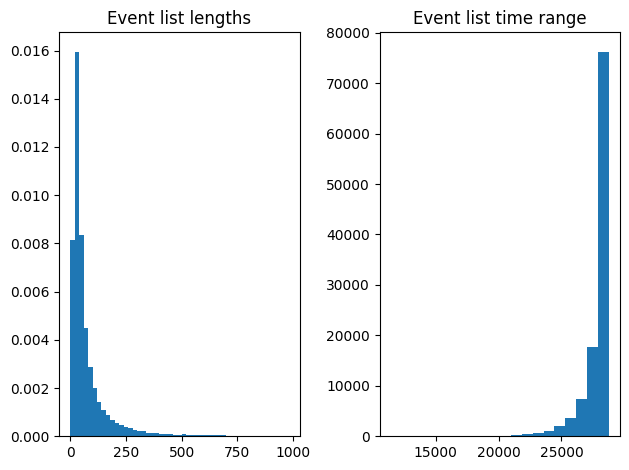

In [32]:
lengths = [len(data_lst[i]['event_list']) for i in range(len(data_lst))]
Ts = [max(data_lst[i]['event_list'][:,0]) for i in range(len(data_lst))]
# Visualization
fig, ax = plt.subplots(1,2)
ax[0].hist(lengths,bins=np.arange(0,1000,20),density=True);
ax[0].set_title('Event list lengths')
# ax[0].set_xscale('log')
# ax[0].set_xlim([0,2000])

ax[1].hist(Ts,bins=20);
ax[1].set_title('Event list time range')
# ax[1].set_xlim([0,200000])
plt.tight_layout()
print(len(Ts))
print(np.quantile(lengths,[0,0.05,0.5,0.95,1]))

## Load pickled files, exploring, Random shift and computing statistics

In [2]:
import pickle

# # Specify the file name

file_name = '../Chandra_data/large_eventfiles_lifetime28800_randomshift.pkl'

with open(file_name, 'rb') as file: 
    data_lst = pickle.load(file)


In [14]:
for i, d in enumerate(data_lst):
    if '22096' in d['id']:
        print(i, d['id'])

4005 22096_12_1
4006 22096_12_2
5646 22096_14_1
5647 22096_14_2
8540 22096_18_1
8541 22096_18_2
9330 22096_19_1
9331 22096_19_2
10473 22096_21_1
10474 22096_21_2
12838 22096_24_1
12839 22096_24_2
17839 22096_31_1
17840 22096_31_2
18473 22096_32_1
18474 22096_32_2
31496 22096_50_1
31497 22096_50_2
45172 22096_80_1
45173 22096_80_2


In [3]:
data_ = compute_statistics(data_lst, 28800)
    
with open(file_name, 'wb') as file:  # Note the 'wb' mode for writing bytes
    pickle.dump(data_lst, file)

/nobackup/users/yankeson/Astronomy/ppae/dataset.py:135: RuntimeWarning: invalid value encountered in long_scalars
  d['hard_ms'] = (med_flux - soft_flux) / (med_flux + soft_flux)
/nobackup/users/yankeson/Astronomy/ppae/dataset.py:134: RuntimeWarning: invalid value encountered in long_scalars
  d['hard_hm'] = (high_flux - med_flux) / (high_flux + med_flux)
/nobackup/users/yankeson/Astronomy/ppae/dataset.py:72: RuntimeWarning: overflow encountered in exp
  Om_list = np.exp(Om_list)
/nobackup/users/yankeson/Astronomy/ppae/dataset.py:74: RuntimeWarning: invalid value encountered in double_scalars
  P = O / (1+O)
/nobackup/users/yankeson/Astronomy/ppae/dataset.py:77: RuntimeWarning: invalid value encountered in divide
  weights = Om_list / np.sum(Om_list)
/nobackup/users/yankeson/Astronomy/ppae/dataset.py:80: RuntimeWarning: invalid value encountered in sqrt
  rates_sd = np.mean(np.sqrt(np.sum(ratesm_list**2 * weights[:, np.newaxis], axis=0) - rates_list**2))
/nobackup/users/yankeson/Astron

In [2]:
# from dataset import random_shift
# data_lst = random_shift(data_lst)
# len(data_lst)

1001

## Filtering

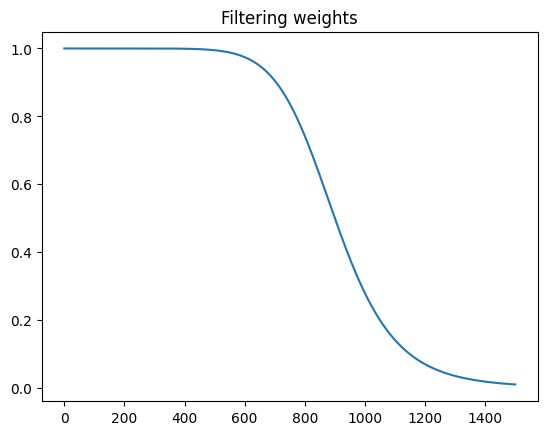

In [16]:
p = 0.01
loc = 900
xs = np.arange(0,1500,0.1)
ys = 1 / (1+np.exp(np.power(loc,1-p)*np.power(xs,p)-loc))
plt.plot(xs,ys)
plt.title('Filtering weights')
plt.savefig(f'../plots/filtering.png')

In [17]:
np.random.seed(2024)
data_lst = []
T_threshold_high = 200000
l_threshold_high = 10000
T_threshold = 28800
l_threshold_low = 10
c = 0
for key in list(raw_events_d.keys()):
    if key in property_ids:
        event_list = np.array(raw_events_d[key])
        event_list[:,0] = event_list[:,0] - min(event_list[:,0])
        T = max(event_list[:,0]) - min(event_list[:,0])
        length = len(event_list)
        if T > T_threshold_high or length > l_threshold_high or T < T_threshold or length < l_threshold_low:
            continue
        else:
            c += 1
            if c % 10000 == 0:
                print(c)
            k = T // T_threshold
            t = 0
            tp = T_threshold
            i = 1
            while True:
                temp_ind = np.where((event_list[:,0] >= t) & (event_list[:,0] < tp))[0]
                temp_list = event_list[temp_ind,:]
                temp_list[:,0] = temp_list[:,0] - min(temp_list[:,0])
                l = len(temp_list)
                if l > l_threshold_low and np.random.rand() >= 1 / (1+np.exp(np.power(loc,1-p)*np.power(l,p)-loc)):
                    data_lst.append({'id':f'{key[1]}_{key[0]}_{i}', 'event_list':temp_list})
                if temp_ind[-1] == length:
                    break
                i += 1
                t = event_list[temp_ind[-1]+1,0]
                tp = t + T_threshold
                if tp > T:
                    break

10000
20000
30000
40000
50000
60000


1001
[ 353.  757. 1242. 4268. 7944.]


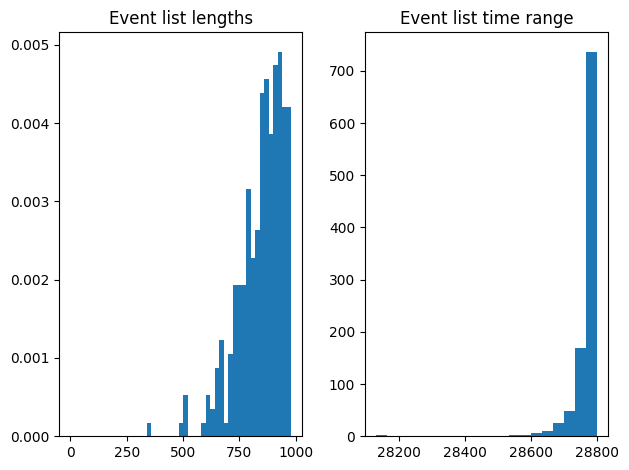

In [18]:
lengths = [len(data_lst[i]['event_list']) for i in range(len(data_lst))]
Ts = [max(data_lst[i]['event_list'][:,0]) for i in range(len(data_lst))]
# Visualization
fig, ax = plt.subplots(1,2)
ax[0].hist(lengths,bins=np.arange(0,1000,20),density=True);
ax[0].set_title('Event list lengths')
# ax[0].set_xscale('log')
# ax[0].set_xlim([0,2000])

ax[1].hist(Ts,bins=20);
ax[1].set_title('Event list time range')
# ax[1].set_xlim([0,200000])
plt.tight_layout()
print(len(Ts))
print(np.quantile(lengths,[0,0.05,0.5,0.95,1]))

In [27]:
import pickle

# # Specify the file name

file_name = '../Chandra_data/small_eventfiles_lifetime43200.pkl'

with open(file_name, 'wb') as file:  # Note the 'wb' mode for writing bytes
    pickle.dump(data_lst, file)
    
# with open(file_name, 'rb') as file: 
#     data_lst = pickle.load(file)

64
333
363
364
365
397
412
591
592


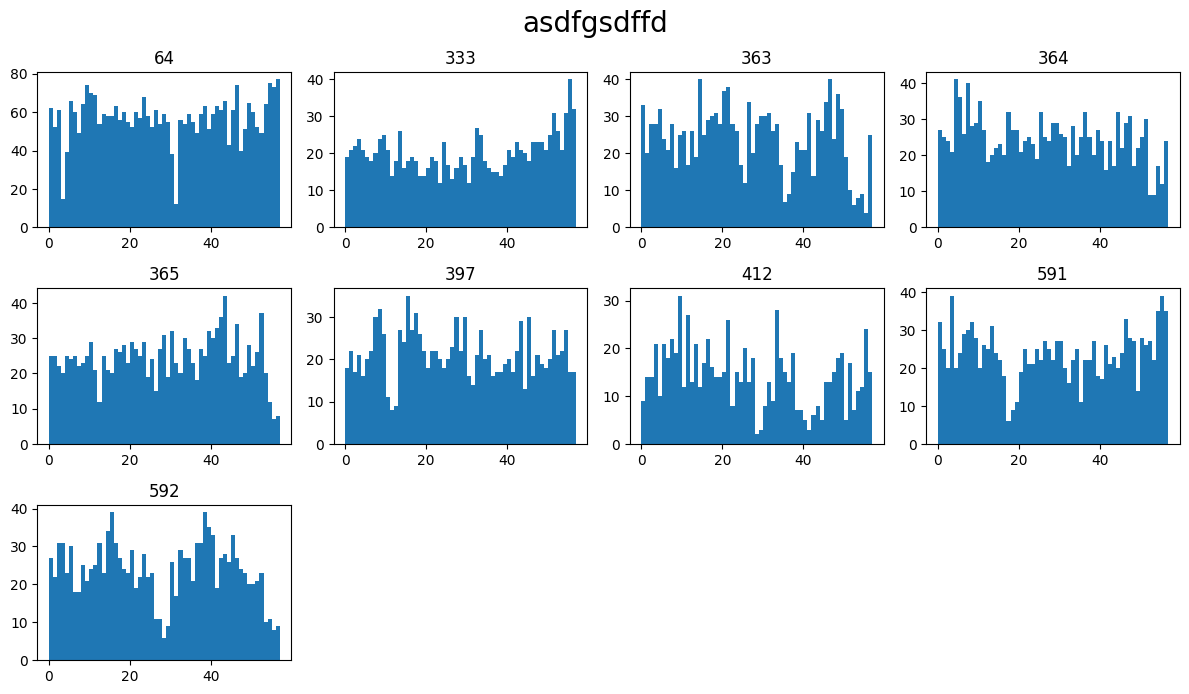

In [22]:
# Look for some interesting eventfiles
flare_ids = set(['1042_24','10822_185','12884_10','13454_56','13610_112','14368_489','14368_503','15113_59','15211_38','2025_39','20635_58','2833_53','3389_274','4062_31','4395_992','5849_62','803_90','9456_274','9548_14','957_208','9875_166'])
dip_ids = set(['10783_10','10871_10','11059_10','11272_13','13812_218','13812_586','13813_218','13814_567','13814_586','4733_229','4736_81','4737_74','5300_95','5322_229','6152_79','6152_81','6170_74','9070_10','942_101','9550_17'])

# Look for flares or dips
plt.figure(figsize=(12,9))
c = 0
for i in range(0,len(data_lst)):
    if data_lst[i]['id'][:-2] in dip_ids:
        times = np.asarray(data_lst[i]['event_list'][:,0]) / 500
        c += 1
        print(i)
        T = max(times)
        plt.subplot(4,4,c)
        plt.hist(times, bins = torch.arange(int(np.ceil(T))))
        plt.title(i)
        if c == 16:
            break
plt.suptitle('asdfgsdffd',size=20)
plt.tight_layout()

# For lightly filtered
# plotting_inds = [297, 1940, 6294, 11123, 11197,  # flares
#                  290, 558, 911, 4683, 5587, 4997, # dips
#                 71, 159, 304, 381, 2024]               # other random ids

# For more filtered
plotting_inds = [709, # flares
                 64, 333, 363, 397, 412, 591, 592, # dips
                71, 159, 304, 381, 118, 42, 513, 832]               # other random ids

# Load small dataset


In [11]:
# # Convert to data dictionary
# true_flares_df_raw = pd.read_csv('../Chandra_data/trueflares.csv')
# false_flares_df_raw = pd.read_csv('../Chandra_data/falseflares.csv')
# true_flares_df = true_flares_df_raw[['time','energy','obsreg_id']]
# false_flares_df = false_flares_df_raw[['time','energy','obsreg_id']]
# starting_times = pd.read_csv('../Chandra_data/starting_time.csv')

# d = true_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict()
# d.update(false_flares_df.groupby('obsreg_id').apply(lambda group: np.array(group[['time', 'energy']])).to_dict())

# # Convert to data list and drop outliers


# data_lst = []
# T_threshold_low = 43200
# num_flares = 436
# i_flare = 0
# for key in list(d.keys()):
#     event_list = d[key]
#     event_list[:,0] = event_list[:,0] - min(event_list[:,0])
#     T = max(event_list[:,0]) - min(event_list[:,0])
#     if T < T_threshold_low:
#         continue
#     else:
#         if i_flare < num_flares:
#             temp_t = starting_times['t'][i_flare] * 1000
#             if temp_t > T - T_threshold_low:
#                 temp_t = T - T_threshold_low
#             i_flare += 1
#         else:
#             temp_t = 0
#         event_list = event_list[(event_list[:,0] >= temp_t) & (event_list[:,0] <= temp_t + T_threshold_low),:]
#         event_list[:,0] = event_list[:,0] - temp_t
#         data_lst.append({'event_list':event_list})


In [4]:
# # Specify the file name
# file_name = '../Chandra_data/small_eventfiles_lifetime43200.pkl'

# # Load and deserialize the list from the file
# with open(file_name, 'wb') as file:  # Note the 'wb' mode for writing bytes
#     pickle.dump(data_lst, file)

with open(f'..//Chandra_data/small_eventfiles_lifetime43200.pkl', 'rb') as file: 
    data_lst = pickle.load(file)

729
[2.0000e+00 4.0400e+01 3.1900e+02 1.9212e+03 9.7300e+03]


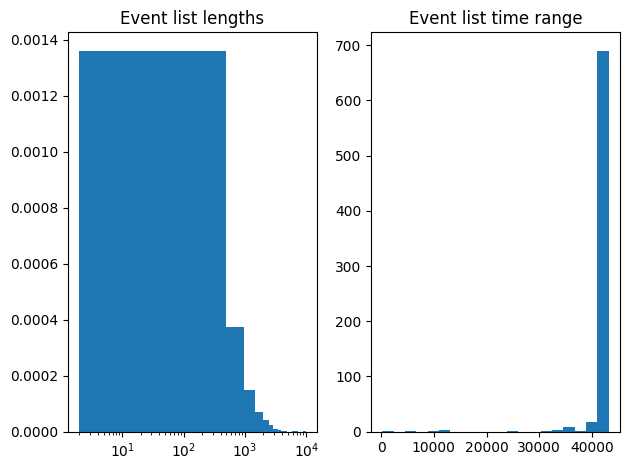

In [5]:
lengths = [len(data_lst[i]['event_list']) for i in range(len(data_lst))]
Ts = [max(data_lst[i]['event_list'][:,0]) for i in range(len(data_lst))]
# Visualization
fig, ax = plt.subplots(1,2)
ax[0].hist(lengths,bins=20,density=True);
ax[0].set_title('Event list lengths')
ax[0].set_xscale('log')
# ax[0].set_xlim([0,2000])

ax[1].hist(Ts,bins=20);
ax[1].set_title('Event list time range')
# ax[1].set_xlim([0,200000])
plt.tight_layout()
print(len(Ts))
print(np.quantile(lengths,[0,0.05,0.5,0.95,1]))

In [17]:
dataset = RealEventsDataset(data_lst,t_scale=5000)

# Load individual eventfiles

In [6]:
fn = f'../Chandra_data/acisf22096_000N020_r0009_regevt3_filter.npz'
file = np.load(fn)
d = {}
event_list = file['event_list']




d['event_list'] = 

In [ ]:
event_list[:,0] = event_list[:,0] - min(event_list[:,0])
        T = max(event_list[:,0]) - min(event_list[:,0])
        
        # Thresholding
        length = len(event_list)
        if T > T_threshold_high or length > l_threshold_high or T < T_threshold or length < l_threshold_low:
            continue
        else:
            # Keep track
            c += 1
            if c % 10000 == 0:
                print(c)
                
            # Divide into windows
            k = T // T_threshold
            t = 0
            tp = T_threshold
            i = 1
            while True:
                temp_ind = np.where((event_list[:,0] >= t) & (event_list[:,0] < tp))[0]
                temp_list = event_list[temp_ind,:]
                temp_list[:,0] = temp_list[:,0] - min(temp_list[:,0])
                l = len(temp_list)
                # if l > l_threshold_low and np.random.rand() >= 1 / (1+np.exp(100*np.pow(x,0.03)-100)):
                if l > l_threshold_low:
                    data_lst.append({'id':f'{key[1]}_{key[0]}_{i}', 'event_list':temp_list})
                if temp_ind[-1] == length:
                    break
                i += 1
                t = event_list[temp_ind[-1]+1,0]
                tp = t + T_threshold
                if tp > T:
                    break